In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_formats = ['svg']

# Training

In [2]:
class BufferContainer:
    def __init__(self, path_dir, detector, episodes=40, steps=60, warmup_steps=16, double_tes=False):
        self.path = "{}{}_v{}/data/{}.npy"
        self.path_dir = path_dir
        self.episodes = episodes
        self.steps = steps
        self.detector = detector
        self.warmup_steps = warmup_steps
        self.double_tes = double_tes
    
    def get(self, which, version):
        if which != 'pulses':
            name = which + '_memory'
            dims = self.episodes, self.steps, -1
            lastone = int(self.episodes*self.steps)
        else:
            name = 'buffer_pulses'
            if self.double_tes:
                ntes = 2
            else:
                ntes = 1
            dims = self.episodes, self.steps, ntes, 256
            lastone = int(2*self.episodes*self.steps)
        data = np.load(self.path.format(self.path_dir, self.detector, version, name))
        data = data[self.warmup_steps:lastone+self.warmup_steps]
        data = data.reshape(dims)
        return data
    
    def check_rewards(self, range_v):
        for v in range(*range_v):
            rewards = self.get('reward', v)
            print(v, ' nmbr reward > 0: ', np.sum(rewards > 0))
            
    def get_tc(self, range_v):
        data = []
        for v in range(*range_v):
            with open('{}{}_v{}/info.txt'.format(self.path_dir, self.detector, v)) as f:
                lines = f.readlines()
            lines = [l for l in lines if l[1:3] == 'Tc']
            lines = lines[0][7:-2].split(' ')[:2]
            data_ = np.array([float(x) for x in lines])
            data.extend(data_)
        return data
    
    def get_g(self, range_v):
        data = []
        for v in range(*range_v):
            with open('{}{}_v{}/info.txt'.format(self.path_dir, self.detector, v)) as f:
                lines = f.readlines()
            lines = [l for l in lines if l[:4] == "'G':"]
            lines = lines[0][7:-2]
            lines = lines.split(' ')
            lines = [l for l in lines if l != '']
            data_ = float(lines[-1])
            data.append(data_)
        return data

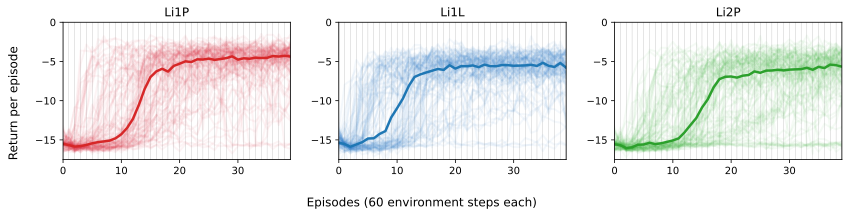

In [3]:
data = []

fig, axes = plt.subplots(1, 3, figsize=(12,3.))

for a,name,tit in zip(axes,['li1p', 'li1l', 'li2p'], ['Li1P', 'Li1L', 'Li2P']):
    
    for i in range(40):
        a.axvline(i, linewidth=.2, color='grey')
    color = 'C3' if name == 'li1p' else 'C0' if name == 'li1l' else 'C2' if name == 'li2p' else None
    buffer = BufferContainer('buffers/', name, double_tes=False, episodes=40)
    steps = np.arange(buffer.episodes)
    curves = []
    for i in np.concatenate((np.arange(0,5),np.arange(10,110))):
        try:
            curves.append(np.sum(np.minimum(buffer.get('reward', i), 0.), axis=1).flatten())
        except ValueError:
            print(name, i)
            continue
        a.plot(steps, curves[-1], color=color, alpha=0.05, linewidth=2)
    data.append(curves)
    a.plot(steps, np.median(np.array(curves), axis=0), color=color, alpha=1., linewidth=2.5)
    a.set_title(tit)
    a.set_ylim(-17.5,0)
    a.set_xlim(0,39)
fig.supylabel('Return per episode')
fig.supxlabel('Episodes (60 environment steps each)')
plt.tight_layout()
plt.savefig('plots_paper/rewards_virtual.png', dpi=300)
plt.show()

In [4]:
data = np.array(data)
data_p = np.mean(data[:,:,:], axis=-1)  # (detector, versions)

In [5]:
data.shape

(3, 105, 40)

In [6]:
hyperpars = {'lr': [3e-4,1e-3,3e-4,3e-4,3e-4,1e-3,1e-3,],
             'bs': [16,16,64,16,16,16,64,],
             'gamma': [0.99,0.99,0.99,0.99,0.9,0.6,0.99,],
             'gs': [20,20,20,100,20,100,20,],
            }

In [7]:
data_p = data_p.reshape(3, 3, 7, 5)  # (detector, phases, hyperps, iterations)

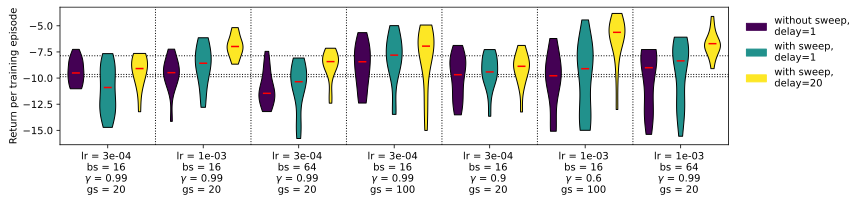

In [8]:
import matplotlib.patches as mpatches

# labels
labels = ['lr = {:.0e} \nbs = {} \n$\gamma$ = {} \ngs = {} '.format(lr, bs, gamma, gs) for lr, bs, gamma, gs in zip(hyperpars['lr'],hyperpars['bs'],hyperpars['gamma'],hyperpars['gs'],)]

## combine these different collections into a list
data_to_plot = [data_p[:,j,i,:].flatten() for i in range(7) for j in range(3)]

# Create a figure instance
fig, ax = plt.subplots(1,1,figsize=(12,3.))

# Create the boxplot
for i in range(3):
    plt.axhline(np.mean(data_to_plot[i::3]), linestyle='dotted', color='black', zorder=1, linewidth=1.)
violin_parts = ax.violinplot(data_to_plot, showextrema=True, showmedians=True)
for i in range(6):
    plt.axvline(3*i+3.5, linestyle='dotted', color='black', linewidth=1.)
violin_parts['cmaxes'].remove()
violin_parts['cmins'].remove()
violin_parts['cbars'].remove()
violin_parts['cmedians'].set_color('red')
for i,pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor('#440154' if i%3 == 0 else '#21918c' if i%3 == 1 else '#fde725')
    pc.set_edgecolor('black')
    pc.set_alpha(1.)
custom_patches = [mpatches.Patch(color='#440154', label='without sweep, \ndelay=1'),
                mpatches.Patch(color='#21918c', label='with sweep, \ndelay=1'),
                mpatches.Patch(color='#fde725', label='with sweep, \ndelay=20')]
ax.legend(handles=custom_patches,
          bbox_to_anchor=(1.2, 1.0), frameon=False)
ax.set_xticks(ticks=np.arange(0,7)*3 + 2, labels=labels)
#ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Return per training episode')
ax.set_xlim(0.5,21.5)
plt.tight_layout()
plt.savefig('plots_paper/parameter_study.png', dpi=300)
plt.show()

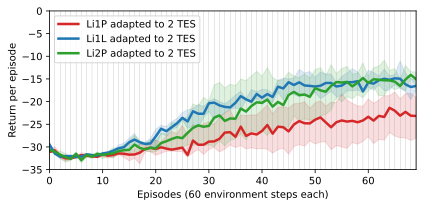

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(6,3))

for i in range(70):
    plt.axvline(i, linewidth=.2, color='grey')

for name,tit in zip(['li1p', 'li1l', 'li2p'], ['Li1P', 'Li1L', 'Li2P']):
    color = 'C3' if name == 'li1p' else 'C0' if name == 'li1l' else 'C2' if name == 'li2p' else None
    buffer = BufferContainer('buffers/', name, double_tes=False, episodes=70)
    steps = np.arange(buffer.episodes)
    curves = []
    for i in range(5,9):
        try:
            curves.append(np.sum(np.minimum(buffer.get('reward', i), 0.), axis=1).flatten())
            # a.plot(steps, curves[-1], color=color, alpha=0.1, linewidth=2)
        except ValueError:
            print(name, i)
            continue
    axes.fill_between(steps, 
                      np.quantile(np.array(curves), q=0.16, axis=0), 
                      np.quantile(np.array(curves), q=0.84, axis=0), 
                      color=color, alpha=.15)
    axes.plot(steps, np.median(np.array(curves), axis=0), color=color, alpha=1., linewidth=2.5, label="{} adapted to 2 TES".format(tit))
    axes.set_ylim(-35,0)
axes.set_xlim(0,69)
axes.set_ylabel('Return per episode')
axes.set_xlabel('Episodes (60 environment steps each)')
axes.legend(loc='upper left')
plt.tight_layout()
plt.savefig('plots_paper/rewards_multi.png', dpi=300)
plt.show()

In [10]:
# for transformer

from copy import deepcopy

d_train = {}
d_validation = {}
d_test = {}

for key, which in zip(['observations', 'actions', 'rewards', 'dones'], 
                      ['state', 'action', 'reward', 'terminal']):
    
    all_buffers = []

    for name in ['li1p', 'li1l', 'li2p']:
        buffer = BufferContainer('buffers/', name)
        for i in np.concatenate((np.arange(0,5),np.arange(10,110))):
            all_buffers.append(buffer.get(which, i))

    all_buffers = np.array(all_buffers).reshape(3, 21, 5, 40, 60, -1)
    if which in ['reward', 'terminal']:
        all_buffers.reshape(3, 21, 5, 40, 60) 
        
    d_train[key] = deepcopy(all_buffers[:,:,:3,:,:].reshape(7560,60,-1).tolist())
    d_validation[key] = deepcopy(all_buffers[:,:,3,:,:].reshape(2520,60,-1).tolist())
    d_test[key] = deepcopy(all_buffers[:,:,4,:,:].reshape(2520,60,-1).tolist())

In [11]:
# so in the end the ordering in the files is first all li1p, then all li1l then all li2p

# then the the ordering is according to the versions

# then it is again to the number of episodes

# so it should be fine to reshape to (3, 21, 5, 40, 60) and take take every fourt detector as validation and every fifth as in the middle index

In [12]:
# for oSAC

state_buffers_train = np.array((3 * 21 * 3 * 40, 60), dtype=float)
action_buffers_train = np.array((3 * 21 * 1 * 40, 60), dtype=float)
reward_buffers_train = np.array((3 * 21 * 1 * 40, 60), dtype=float)

for which in ['state', 'action', 'reward']:
    
    all_buffers = []

    for name in ['li1p', 'li1l', 'li2p']:
        buffer = BufferContainer('buffers/', name)
        for i in np.concatenate((np.arange(0,5),np.arange(10,110))):
            all_buffers.append(buffer.get(which, i))

    all_buffers = np.array(all_buffers).reshape(3, 21, 5, 40, 60, -1)
    if which in ['reward', 'terminal']:
        all_buffers.reshape(3, 21, 5, 40, 60) 


In [13]:
# make dataset for transformer training
from datasets import load_dataset, DatasetDict, Dataset
import pandas as pd


In [14]:
for split in ['train', 'validation', 'test']:
    df = pd.DataFrame(data=eval('d_{}'.format(split)))
    df.to_pickle('saved_pars/transformer_dataset_{}.pkl'.format(split))

In [15]:
dataset_train = load_dataset("pandas", data_files="saved_pars/transformer_dataset_train.pkl")
dataset_validation = load_dataset("pandas", data_files="saved_pars/transformer_dataset_validation.pkl")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset pandas downloaded and prepared to /users/felix.wagner/.cache/huggingface/datasets/pandas/default-21302aee5d8248ec/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset pandas downloaded and prepared to /users/felix.wagner/.cache/huggingface/datasets/pandas/default-30f0f8d230893acc/0.0.0/3ac4ffc4563c796122ef66899b9485a3f1a977553e2d2a8a318c72b8cc6f2202. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
dataset_validation

DatasetDict({
    train: Dataset({
        features: ['observations', 'actions', 'rewards', 'dones'],
        num_rows: 2520
    })
})

# Inference

In [33]:
dt_returns = np.zeros((3, 21, 60))
dt_dacs = np.zeros((3, 21, 60))
dt_ibs = np.zeros((3, 21, 60))
dt_pulse_counter = np.zeros((3, 21, 60), dtype=bool)
dt_op = np.zeros((3, 21, 60))

sac_returns = np.zeros((3, 21, 60))
sac_dacs = np.zeros((3, 21, 60))
sac_ibs = np.zeros((3, 21, 60))
sac_pulse_counter = np.zeros((3, 21, 60), dtype=bool)
sac_op = np.zeros((3, 21, 60))

for i,name in enumerate(['li1p', 'li1l', 'li2p', ]):
    j = 0
    for version in range(4,110,5):
        if version == 9:
            continue
        
        df = pd.read_csv('buffers_inf_dt_40mretrain/{}_v{}/data/buffer.csv'.format(name, version))
        
        dt_returns[i,j] = - df['RMS (V)'][-120::2]/np.maximum(df['Pulse height (V)'][-120::2], df['RMS (V)'][-120::2])
        dt_dacs[i,j] = df['DAC output (V)'][-120::2]
        dt_ibs[i,j] = df['Bias current (muA)'][-120::2]
        dt_pulse_counter[i,j] = np.logical_and(df['TES resistance / normal conducting'][-120::2] < 0.9, df['TES resistance / normal conducting'][-120::2] > 0.1)
        dt_op[i,j] = df['TES resistance / normal conducting'][-120::2]
        
        df = pd.read_csv('buffers_inf_sac/{}_v{}/data/buffer.csv'.format(name, version))
        
        sac_returns[i,j] = - df['RMS (V)'][-120::2]/np.maximum(df['Pulse height (V)'][-120::2], df['RMS (V)'][-120::2])
        sac_dacs[i,j] = df['DAC output (V)'][-120::2]
        sac_ibs[i,j] = df['Bias current (muA)'][-120::2]
        sac_pulse_counter[i,j] = np.logical_and(df['TES resistance / normal conducting'][-120::2] < 0.9, df['TES resistance / normal conducting'][-120::2] > 0.1)
        sac_op[i,j] = df['TES resistance / normal conducting'][-120::2]
        
        j+=1

In [34]:
print('SAC \t \t \t ', np.mean(sac_returns))
print('DT 40 M \t \t ', np.mean(dt_returns))
print('DT 40 M retrain \t ', np.mean(dt_returns))

# SAC             -0.08456634376125434
# DT 40 M         -0.17657258427775746
# DT 40 M retrain -0.18991568458386818

SAC 	 	 	  -0.08456634376125434
DT 40 M 	 	  -0.18991568458386818
DT 40 M retrain 	  -0.18991568458386818


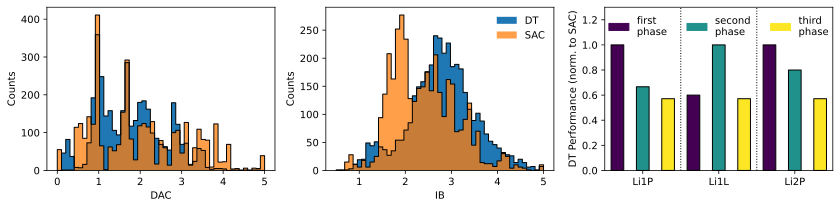

In [20]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 3, figsize=(12,3.),)

axes[0].hist(dt_dacs.flatten(), bins=np.linspace(0,5,50), histtype='stepfilled', linewidth=2, label='DT')
axes[0].hist(dt_dacs.flatten(), bins=np.linspace(0,5,50), histtype='step', color='C0', edgecolor='black', linewidth=1)
axes[0].hist(sac_dacs.flatten(), bins=np.linspace(0,5,50), histtype='stepfilled', linewidth=2, alpha=0.75, label='SAC')
axes[0].hist(sac_dacs.flatten(), bins=np.linspace(0,5,50), histtype='step', color='C1', edgecolor='black', linewidth=1)
#axes[0].legend()
axes[0].set_xlabel('DAC')
axes[0].set_ylabel('Counts')

axes[1].hist(dt_ibs.flatten(), bins=np.linspace(0.5,5,50), histtype='stepfilled', linewidth=2, label='DT')
axes[1].hist(dt_ibs.flatten(), bins=np.linspace(0.5,5,50), histtype='step', color='C0', edgecolor='black', linewidth=1)
axes[1].hist(sac_ibs.flatten(), bins=np.linspace(0.5,5,50), histtype='stepfilled', linewidth=2, alpha=0.75, label='SAC')
axes[1].hist(sac_ibs.flatten(), bins=np.linspace(0.5,5,50), histtype='step', color='C1', edgecolor='black', linewidth=1)
axes[1].legend(frameon=False)
axes[1].set_xlabel('IB')
axes[1].set_ylabel('Counts')

values = np.sum(np.sum(dt_pulse_counter, axis=-1).reshape(3,3,7) > 10, axis=-1) / np.sum(np.sum(sac_pulse_counter, axis=-1).reshape(3,3,7) > 10, axis=-1)

for p,col in enumerate(['#440154', '#21918c', '#fde725']):
    for i in range(3):
        # axes[2].scatter(3*i+p-1, values[i,p], color=col, edgecolor='black', s=100, marker='X')
        axes[2].bar(3*i+p-1, values[i,p], color=col, edgecolor='black', width = 0.5)

labels = ['Li1P','Li1L','Li2P']
axes[2].set_xticks(ticks=np.arange(0,9,3), labels=labels)
# axes[2].axhline(1, color='black', linestyle='dotted', linewidth=1.)
for x in [1.5, 4.5]:
    axes[2].axvline(x, color='black', linestyle='dotted', linewidth=1.)
axes[2].set_ylabel('DT Performance (norm. to SAC)')
axes[2].set_xlim(-1.5,7.5)
axes[2].set_ylim(.0,1.3)
custom_patches = [mpatches.Patch(color='#440154', label='first\nphase'),
                mpatches.Patch(color='#21918c', label='second\nphase'),
                mpatches.Patch(color='#fde725', label='third\nphase')]
axes[2].legend(handles=custom_patches, frameon=False, ncol=3, loc='upper center')

plt.tight_layout()
plt.savefig('plots_paper/decision_transformer.png', dpi=300)
plt.show()

In [21]:
np.mean(values)

0.7534391534391534

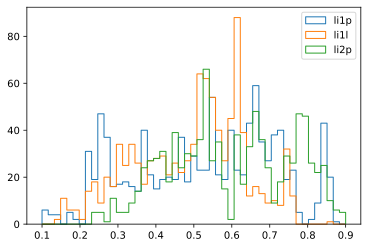

In [22]:
plt.hist(sac_op[0,:,:].flatten(), label='li1p', bins=np.linspace(0.1,0.9,50), histtype='step')
plt.hist(sac_op[1,:,:].flatten(), label='li1l', bins=np.linspace(0.1,0.9,50), histtype='step')
plt.hist(sac_op[2,:,:].flatten(), label='li2p', bins=np.linspace(0.1,0.9,50), histtype='step')
plt.legend()
plt.show()